In [3]:
from scipy.interpolate import interp1d
import numpy as np
import hapke
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import interp1d
import os
import shutil
from pyvims import VIMS

def hapke_model(parameters, wav, eme, inc, phase):
    # Unpack the parameters
    # Assuming you have parameters p1, p2, p3, etc.
    phi, D, theta_bar = parameters

    # Calculate the modeled spectrum using Hapke model equations
    # Replace with your own implementation

    psi = hapke.phasetoazimuth(phase,eme,inc)


    B_S0 = 0.53
    b = 0.2
    B_C0 = 0.35

    transport_mean_free_path = 33 * 10 ** (-6)

    K = hapke.porosityparameter(phi)

    B_SH = hapke.shoe(B_S0,phi,phase)
    c = hapke.hockey_stick(b)

    p = hapke.phase_function(b, c, phase)
    [mu_0e, mu_e, S] = hapke.shadowingfunction(inc, eme, psi, theta_bar)


    w = []
    for i in range(len(n_range)):
        w.append(hapke.singlescatteringalbedo(n_range[i], k_range[i], wav[i], D))

    B_CB = []
    for i in range(len(wav)):
        B_CB.append(hapke.cboe(B_C0,transport_mean_free_path,wav[i],phase,K))

    r = []
    for i in range(len(wav)):
        r.append(K * w[i]/(4*np.pi) * mu_0e/(mu_0e + mu_e) * (p * B_SH + hapke.H(w[i], mu_0e) * hapke.H(w[i], mu_e) - 1) * B_CB[i] * S)

    IF = []
    for i in range(len(wav)):
        IF.append(r[i]*np.pi)


    return IF

def cost_function(parameters, hapke_wav, eme, inc, phase, measured_IF, measured_wav):

    IF_hapke = hapke_model(parameters, hapke_wav, eme, inc, phase)

    wav_new = np.clip(np.array(measured_wav), np.array(hapke_wav).min(), np.array(hapke_wav).max())

    interp_func = interp1d(hapke_wav, IF_hapke, kind='linear')

    # Interpolate y2 values at x_new
    interpolated_hapke = interp_func(wav_new)


    difference = interpolated_hapke - measured_IF

    return difference

listo


In [4]:
# DOWNLOAD THE CUBE AND ALLOCATE IT TO THE RIGHT FOLDER

cube_id = '1671591682_1'

directory = 'C:/Users/USUARIO/Desktop/MSc Thesis/Phase A - Data Analysis/Data/'
cube = VIMS(cube_id,root=directory)

origin = directory + cube.fname
destination = directory + cube.target_name + '/' + str(cube.flyby)

# If the folder does not exist, create it

if not os.path.exists(destination):
    os.mkdir(destination)
    print("New folder created")

if os.path.exists(destination + '/' + cube.fname):
    print("Existing Cube")
else:
    shutil.move(origin, destination)

print("Cube saved in: " + destination)

cube

Existing Cube
Cube saved in: C:/Users/USUARIO/Desktop/MSc Thesis/Phase A - Data Analysis/Data/ENCELADUS/E13


<VIMS> Cube: 1671591682_1
 - Size: (46, 46)
 - Channel: IR
 - Mode: NORMAL
 - Start time: 2010-12-21 02:14:11.350000+00:00
 - Stop time: 2010-12-21 02:17:36.403000+00:00
 - Exposure: 0.0915525 sec
 - Duration: 0:03:25.053000
 - Main target: ENCELADUS
 - Flyby: E13

In [18]:
data = np.loadtxt('./Optical Constants/Crystalline_120.txt')

# OPTICAL RANGE OF THE VIMS INSTRUMENT

max_wavelength = 5.1
min_wavelength = 0.35

wavelength1 = [row[0] for row in data]
n = [row[1] for row in data]
k = [row[2] for row in data]

indices = [i for i in range(len(wavelength1)) if min_wavelength <= wavelength1[i] <= max_wavelength]


# Extract wavelength, n, and k values within desired range
wavelength_range1 = [wavelength1[i] for i in indices]
n_range = [n[i] for i in indices]
k_range = [k[i] for i in indices]

In [19]:
pixel1 = cube@(36, 15)

i = np.deg2rad(pixel1.inc)
e = np.deg2rad(pixel1.eme)
g = np.deg2rad(pixel1.phase)

print(pixel1.inc,pixel1.eme,pixel1.phase)

IF1 = pixel1.spectrum
wav1 = pixel1.wvlns

gamma = np.arctan((np.cos(i))/(np.cos(e)*np.sin(g)) - 1 / np.tan(g))
beta = np.cos(e)/np.cos(gamma)

disk_f = np.cos(g/2)*np.cos((np.pi/(np.pi-g))*(gamma-g/2))*beta**(g/(np.pi-g))/np.cos(gamma)
albedo = IF1/(disk_f*(1-0.3651*g))



ini_par = [0.30, 0.00001, np.deg2rad(20)]

optimized_parameters = optimize.least_squares(
    cost_function, ini_par, args=(wavelength_range1, e, i, g, IF1, wav1), bounds=([0.0,0.0,0.0], [0.75,0.0001,np.deg2rad(45)])
)

53.01319710728901 49.93917887149129 14.39452822011539


     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-5.252e-03 -1.250e-02 ...  1.959e-02  1.581e-02]
           x: [ 2.581e-04  4.684e-05  4.725e-07]
        cost: 0.14777352895822424
         jac: [[ 4.577e+00 -4.256e+02 -8.196e-07]
               [ 4.577e+00 -4.256e+02 -8.196e-07]
               ...
               [ 5.639e-01 -1.682e+03 -7.451e-09]
               [ 5.639e-01 -1.682e+03 -7.451e-09]]
        grad: [ 1.269e-05 -6.107e-02  5.947e-08]
  optimality: 3.24600159617651e-06
 active_mask: [0 0 0]
        nfev: 31
        njev: 18


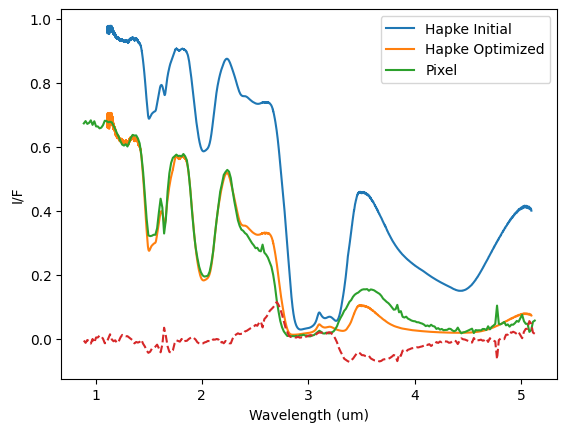

In [20]:
print(optimized_parameters)
optimized_values = optimized_parameters.x
new_hapke = hapke_model(optimized_parameters.x,wavelength_range1,e,i,g)

fig, ax = plt.subplots()
ax.plot(wavelength_range1, hapke_model(ini_par,wavelength_range1,e,i,g), label = 'Hapke Initial')
ax.plot(wavelength_range1, new_hapke, label = 'Hapke Optimized')
ax.plot(wav1, IF1, label = 'Pixel')
ax.plot(wav1, optimized_parameters.fun, ls = '--')
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('I/F')
ax.set_title('')
ax.legend()
plt.show()

In [23]:
optimized_values = optimized_parameters.x

# Retrieve the covariance matrix
cov_matrix = np.linalg.inv(optimized_parameters.jac.T @ optimized_parameters.jac)

# Calculate the standard errors of the optimized parameters
parameter_errors = np.sqrt(np.diag(cov_matrix))

# Print the optimized parameter values and their errors
for i, value in enumerate(optimized_values):
    print(f"Parameter {i+1}: {value:} +/- {parameter_errors[i]:.4f}")

# Calculate correlation matrix
correlation_matrix = cov_matrix / np.outer(parameter_errors, parameter_errors)

print("Correlation matrix:")
print(correlation_matrix)

Parameter 1: 0.00025809440533133707 +/- 0.3387
Parameter 2: 4.68440746120449e-05 +/- 0.0002
Parameter 3: 4.7250135285189826e-07 +/- 1893213.6854
Correlation matrix:
[[1.         0.96488315 0.99350101]
 [0.96488315 1.         0.94540656]
 [0.99350101 0.94540656 1.        ]]


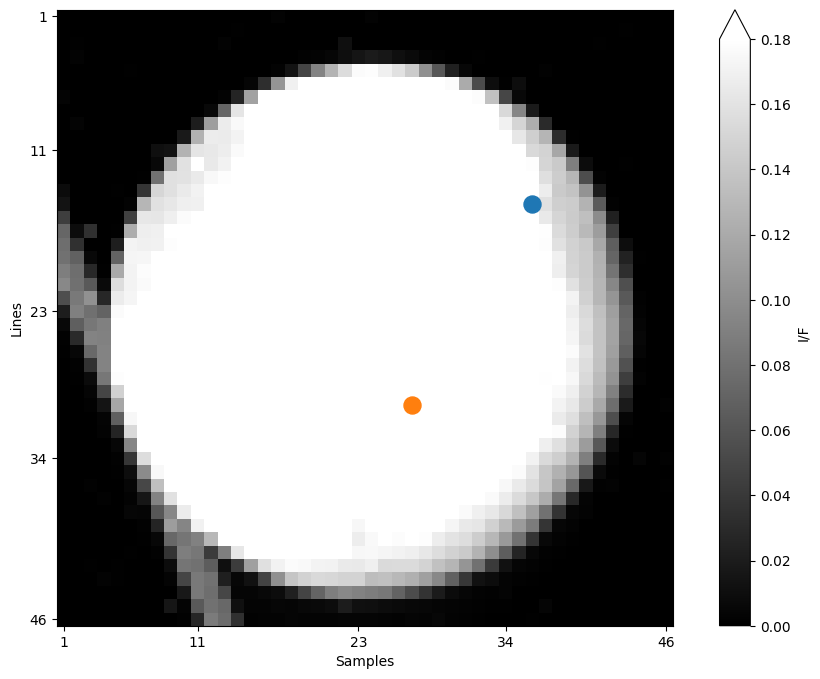

In [24]:
plt.figure(figsize=(12, 8))

plt.imshow(cube@2.03, extent=cube.extent, cmap='gray', vmin=0, vmax=.18)

plt.colorbar(extend='max', label='I/F')

plt.scatter(36, 15, s=150)
plt.scatter(27, 30, s=150)

plt.xlabel(cube.slabel)
plt.ylabel(cube.llabel)

plt.xticks(cube.sticks)
plt.yticks(cube.lticks);

In [25]:
pixel1 = cube@(27, 30)

i = np.deg2rad(pixel1.inc)
e = np.deg2rad(pixel1.eme)
g = np.deg2rad(pixel1.phase)

print(pixel1.inc,pixel1.eme,pixel1.phase)

IF1 = pixel1.spectrum
wav1 = pixel1.wvlns

gamma = np.arctan((np.cos(i))/(np.cos(e)*np.sin(g)) - 1 / np.tan(g))
beta = np.cos(e)/np.cos(gamma)

disk_f = np.cos(g/2)*np.cos((np.pi/(np.pi-g))*(gamma-g/2))*beta**(g/(np.pi-g))/np.cos(gamma)
albedo = IF1/(disk_f*(1-0.3651*g))



ini_par = [0.30, 0.00001, np.deg2rad(20)]

optimized_parameters = optimize.least_squares(
    cost_function, ini_par, args=(wavelength_range1, e, i, g, IF1, wav1), bounds=([0.0,0.0,0.0], [0.75,0.0001,np.deg2rad(45)])
)

29.501982643014678 15.764636677294009 14.322567512448385


     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-7.504e-03 -1.681e-02 ...  3.609e-02  4.186e-02]
           x: [ 3.987e-16  3.952e-05  4.239e-01]
        cost: 0.1616298377841955
         jac: [[ 2.241e+02 -6.131e+02 -7.064e-01]
               [ 2.241e+02 -6.131e+02 -7.064e-01]
               ...
               [ 2.610e+01 -2.297e+03 -5.826e-03]
               [ 2.610e+01 -2.297e+03 -5.826e-03]]
        grad: [ 8.897e+00  5.931e-02  4.306e-05]
  optimality: 1.8254095661830056e-05
 active_mask: [-1  0  0]
        nfev: 25
        njev: 18


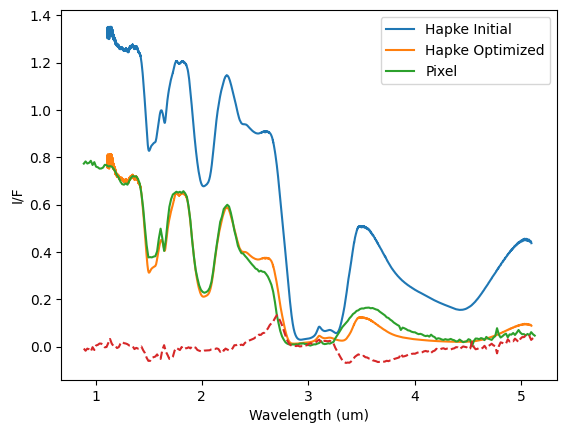

In [26]:
print(optimized_parameters)
optimized_values = optimized_parameters.x
new_hapke = hapke_model(optimized_parameters.x,wavelength_range1,e,i,g)

fig, ax = plt.subplots()
ax.plot(wavelength_range1, hapke_model(ini_par,wavelength_range1,e,i,g), label = 'Hapke Initial')
ax.plot(wavelength_range1, new_hapke, label = 'Hapke Optimized')
ax.plot(wav1, IF1, label = 'Pixel')
ax.plot(wav1, optimized_parameters.fun, ls = '--')
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('I/F')
ax.set_title('')
ax.legend()
plt.show()

In [28]:
optimized_values = optimized_parameters.x

# Retrieve the covariance matrix
cov_matrix = np.linalg.inv(optimized_parameters.jac.T @ optimized_parameters.jac)

# Calculate the standard errors of the optimized parameters
parameter_errors = np.sqrt(np.diag(cov_matrix))

# Print the optimized parameter values and their errors
for i, value in enumerate(optimized_values):
    print(f"Parameter {i+1}: {value:} +/- {parameter_errors[i]:.4f}")

correlation_matrix = cov_matrix / np.outer(parameter_errors, parameter_errors)

print("Correlation matrix:")
print(correlation_matrix)

Parameter 1: 3.986826828016954e-16 +/- 0.0077
Parameter 2: 3.951912423812276e-05 +/- 0.0001
Parameter 3: 0.42389589787873294 +/- 2.4498
Correlation matrix:
[[1.         0.96499133 0.99467115]
 [0.96499133 1.         0.94762433]
 [0.99467115 0.94762433 1.        ]]
